### This notebook implements the SDP method on the Pavia University Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm import trange
from tqdm.auto import tqdm
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
import scipy.sparse as sp
from enum import Enum
from dataclasses import dataclass
from typing import Tuple

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init    
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table, parameter_count

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

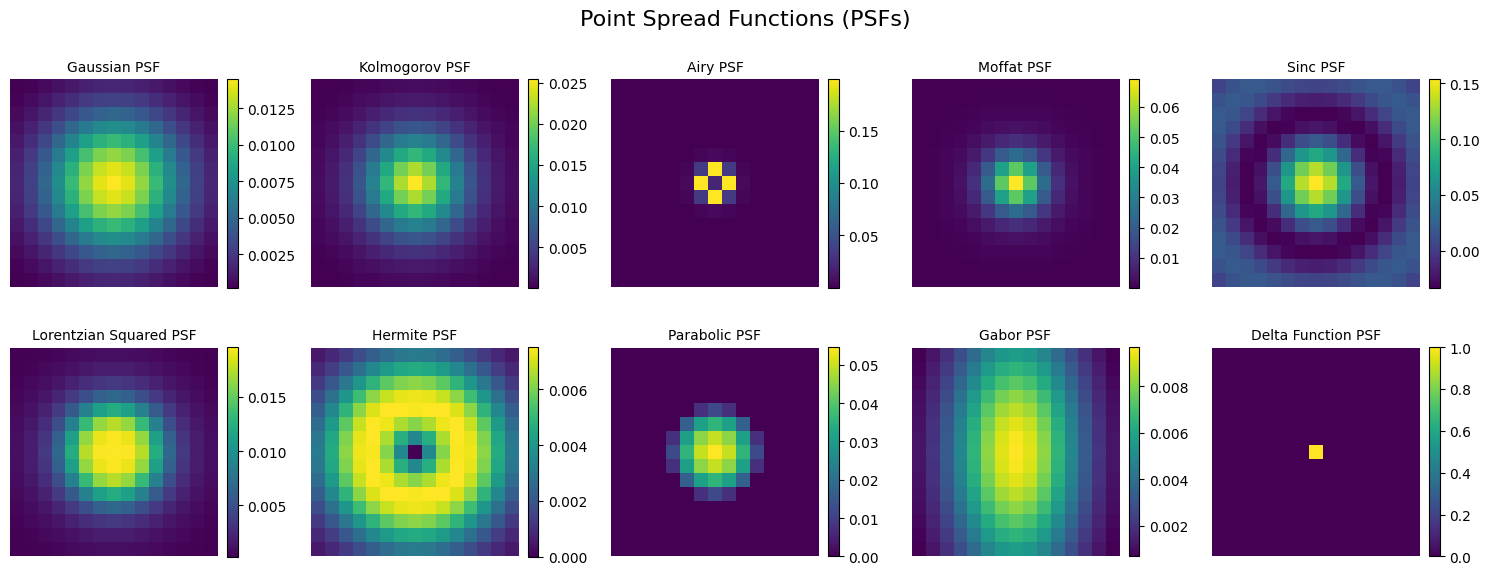

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img, bands, title):
    """
    Visualize a hyperspectral image by converting it to an RGB representation.
    
    Parameters:
    -----------
    img : np.ndarray
        Hyperspectral image array.
    bands : tuple
        Band indices to use for RGB representation.
    title : str
        Title for the plot.
    """
    img_rgb = get_rgb(img, bands)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Pavia University

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_University_data.mat')

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth image shape:  (610, 340, 103)


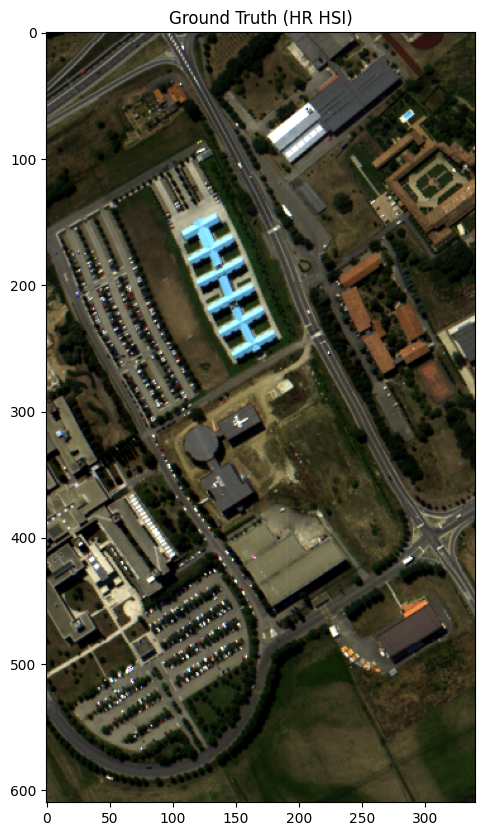

MSI shape:  (610, 340, 1)


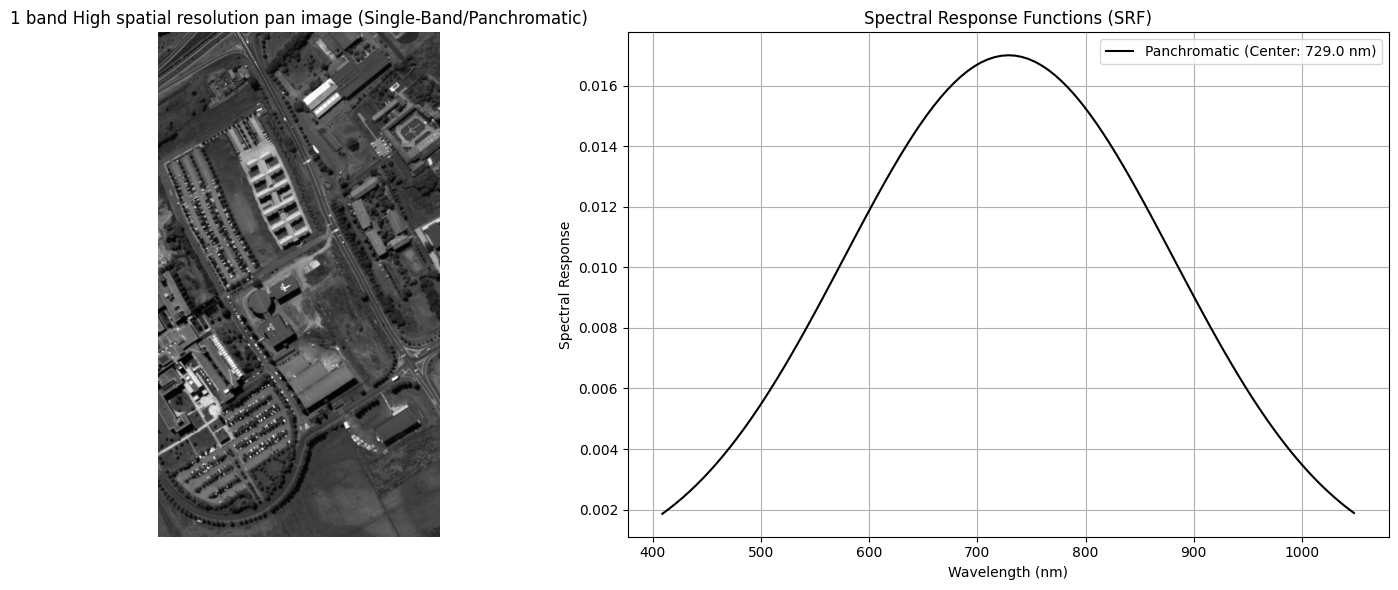

MSI shape:  (610, 340, 3)


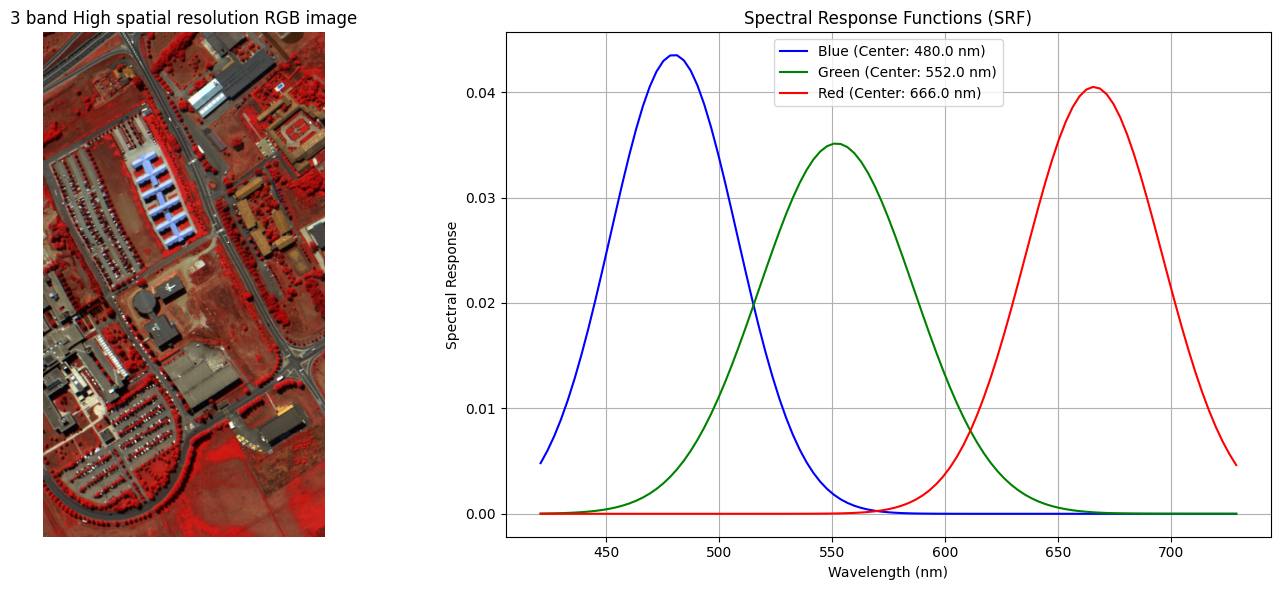

MSI shape:  (610, 340, 4)


In [ ]:
pavia_university = sio.loadmat(mat_file_path)
pavia_university_image = pavia_university['paviaU']

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_university_image)
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi(I_REF, (50,35,15), "Ground Truth (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=1, fwhm_factor=4.2)
print("MSI shape: ", I_MS_1.shape)
plot_multispectral_with_srf(I_MS_1, None, "1 band High spatial resolution pan image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=4, fwhm_factor=4.2)
print("MSI shape: ", I_MS_4.shape)
plot_multispectral_with_srf(I_MS_4, (2,1,0), "4 band High spatial resolution MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=8, fwhm_factor=4.2)
print("MSI shape: ", I_MS_8.shape)
plot_multispectral_with_srf(I_MS_8, (4,2,1), "8 band High spatial resolution MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=16, fwhm_factor=4.2)
print("MSI shape: ", I_MS_16.shape)
plot_multispectral_with_srf(I_MS_16, (4,2,1), "16 band High spatial resolution MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI shape with 4x Downsample:  (152, 85, 103)


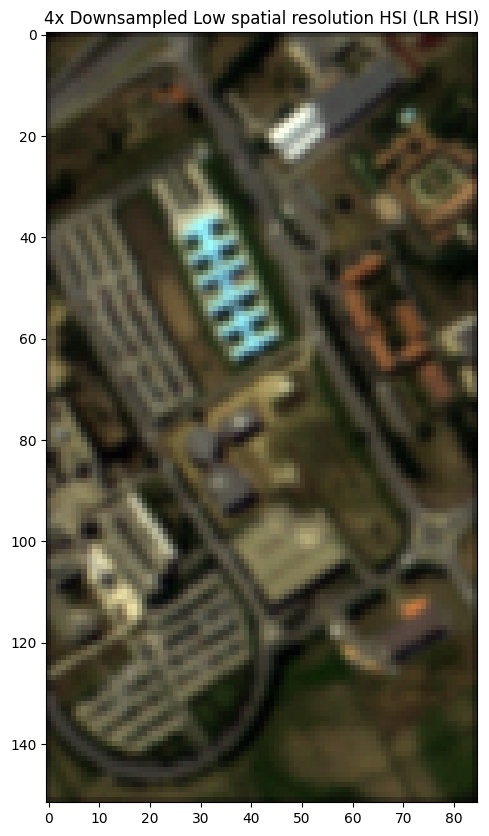

HSI shape with 8x Downsample:  (76, 42, 103)


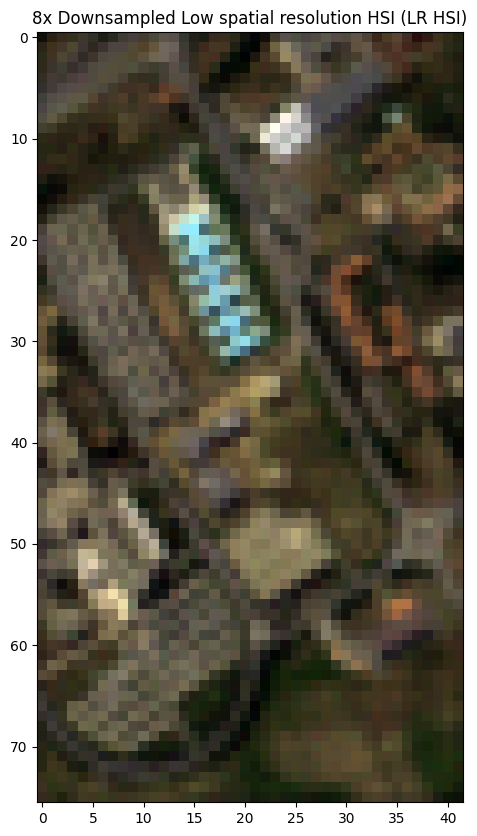

HSI shape with 16x Downsample:  (38, 21, 103)


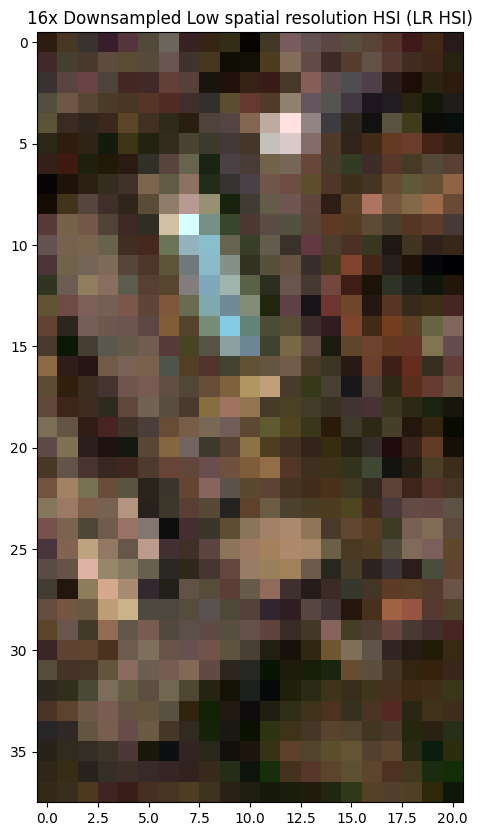

HSI shape with 32x Downsample:  (19, 10, 103)


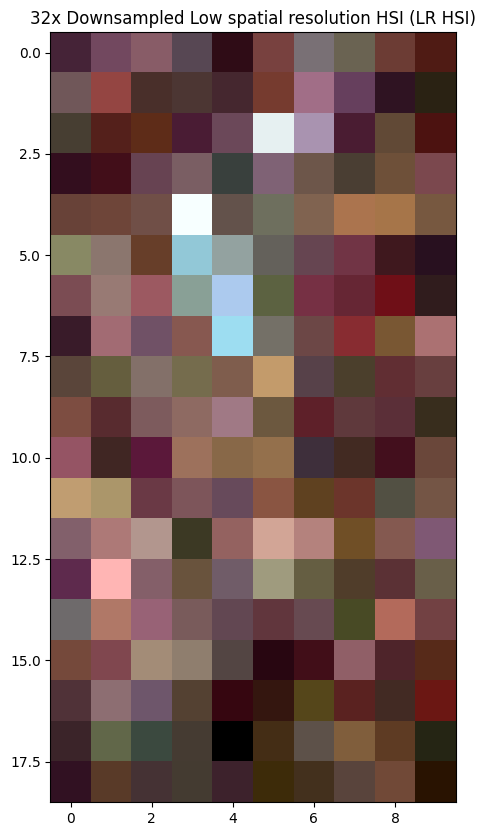

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(pavia_university_image, gaus_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gaus.shape)
visualize_hsi(I_HS_4_gaus, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_university_image, gaus_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi(I_HS_8_gaus, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(pavia_university_image, gaus_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gaus.shape)
visualize_hsi(I_HS_16_gaus, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(pavia_university_image, gaus_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gaus.shape)
visualize_hsi(I_HS_32_gaus, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI shape with 4x Downsample:  (152, 85, 103)


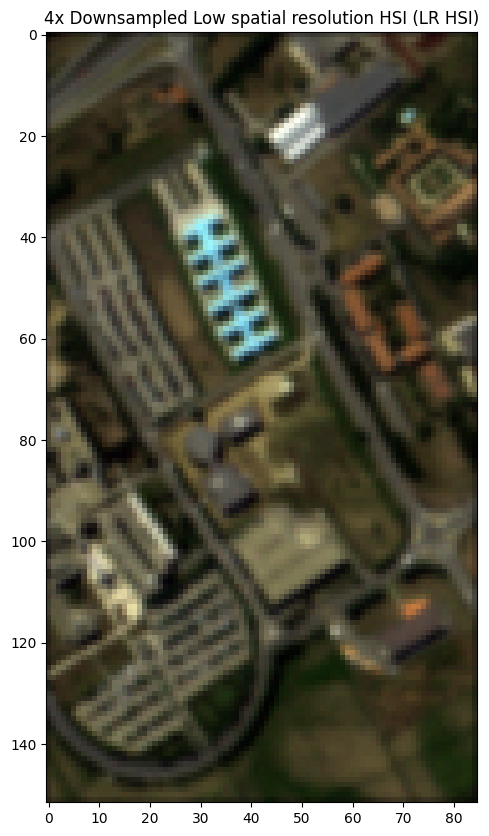

HSI shape with 8x Downsample:  (76, 42, 103)


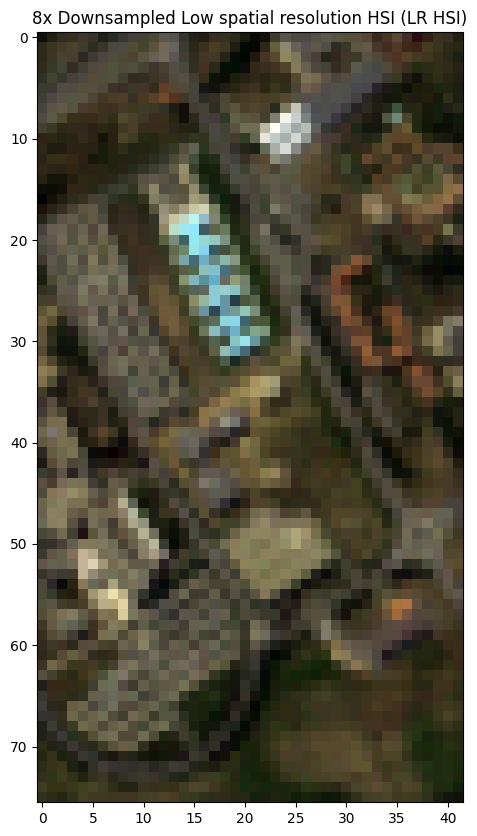

HSI shape with 16x Downsample:  (38, 21, 103)


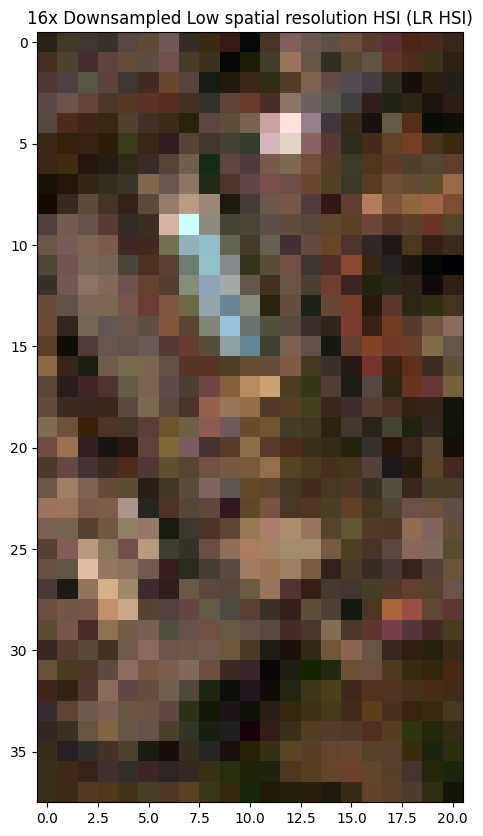

HSI shape with 32x Downsample:  (19, 10, 103)


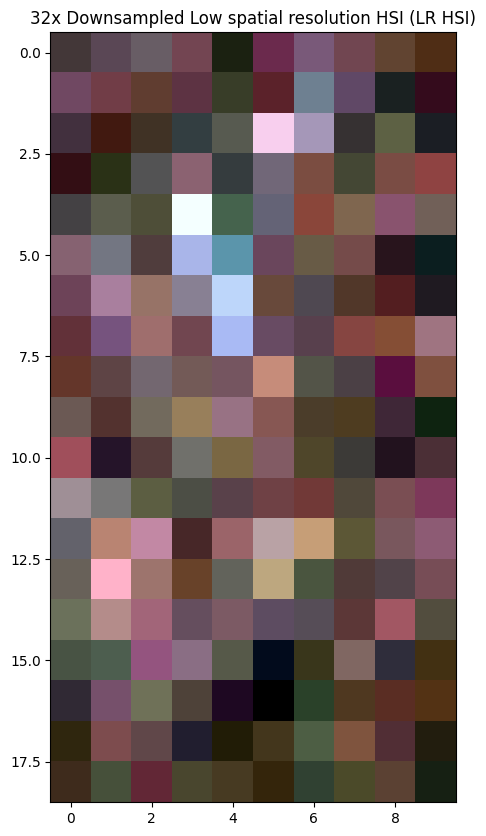

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(pavia_university_image, kol_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_kol.shape)
visualize_hsi(I_HS_4_kol, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(pavia_university_image, kol_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_kol.shape)
visualize_hsi(I_HS_8_kol, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(pavia_university_image, kol_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_kol.shape)
visualize_hsi(I_HS_16_kol, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(pavia_university_image, kol_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_kol.shape)
visualize_hsi(I_HS_32_kol, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Airy PSF

In [ ]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(pavia_university_image, air_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_air.shape)
visualize_hsi(I_HS_4_air, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(pavia_university_image, air_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_air.shape)
visualize_hsi(I_HS_8_air, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(pavia_university_image, air_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_air.shape)
visualize_hsi(I_HS_16_air, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(pavia_university_image, air_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_air.shape)
visualize_hsi(I_HS_32_air, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Moffat PSF

HSI shape with 4x Downsample:  (152, 85, 103)


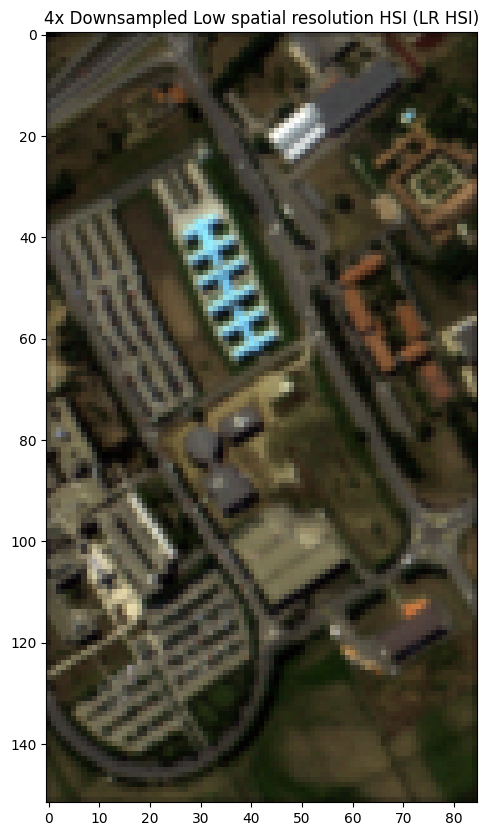

HSI shape with 8x Downsample:  (76, 42, 103)


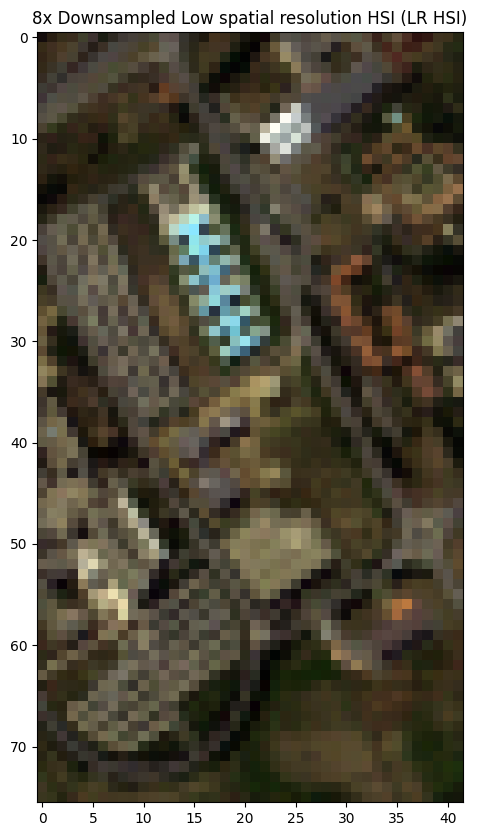

HSI shape with 16x Downsample:  (38, 21, 103)


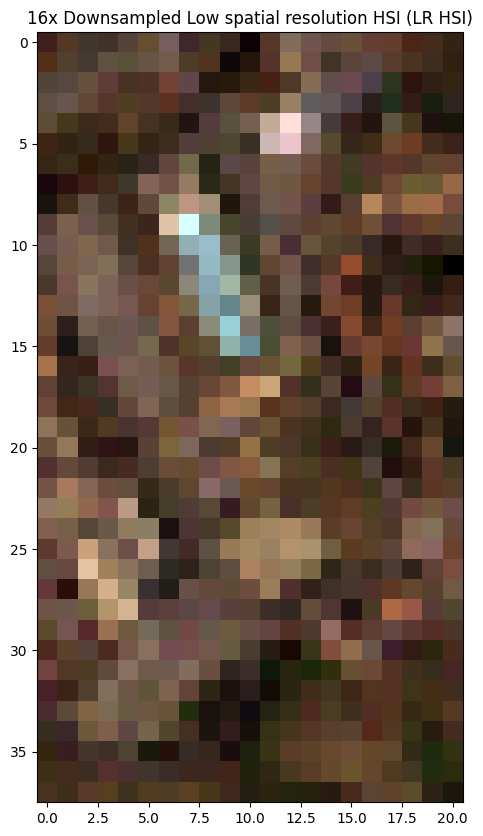

HSI shape with 32x Downsample:  (19, 10, 103)


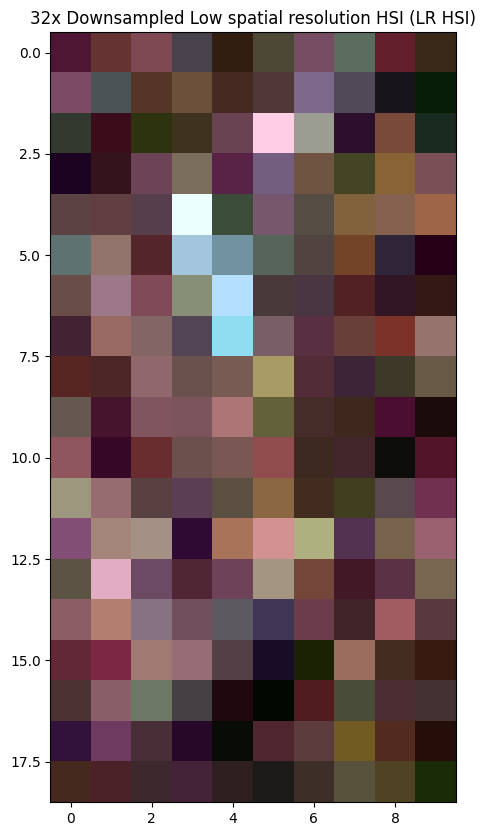

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(pavia_university_image, mof_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_mof.shape)
visualize_hsi(I_HS_4_mof, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(pavia_university_image, mof_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_mof.shape)
visualize_hsi(I_HS_8_mof, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(pavia_university_image, mof_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_mof.shape)
visualize_hsi(I_HS_16_mof, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(pavia_university_image, mof_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_mof.shape)
visualize_hsi(I_HS_32_mof, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Sinc PSF

HSI shape with 4x Downsample:  (152, 85, 103)


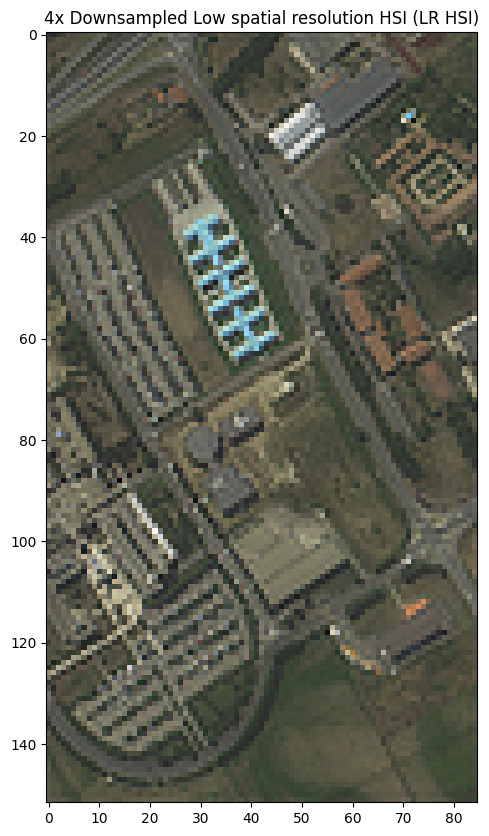

HSI shape with 8x Downsample:  (76, 42, 103)


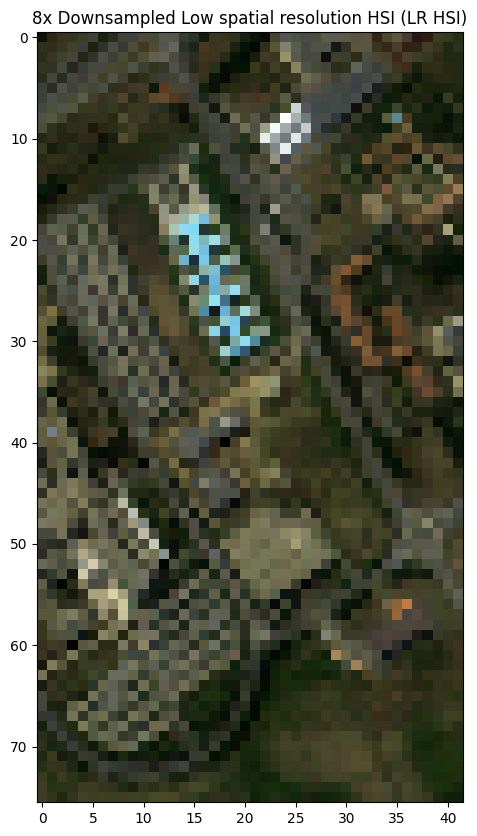

HSI shape with 16x Downsample:  (38, 21, 103)


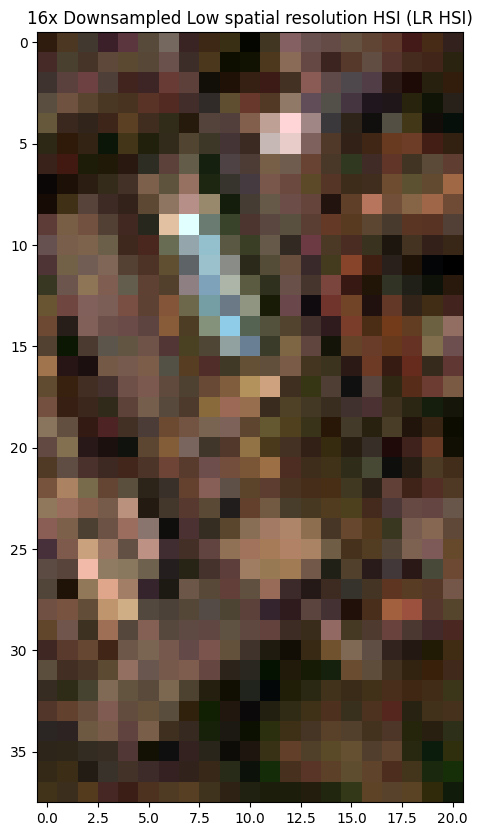

HSI shape with 32x Downsample:  (19, 10, 103)


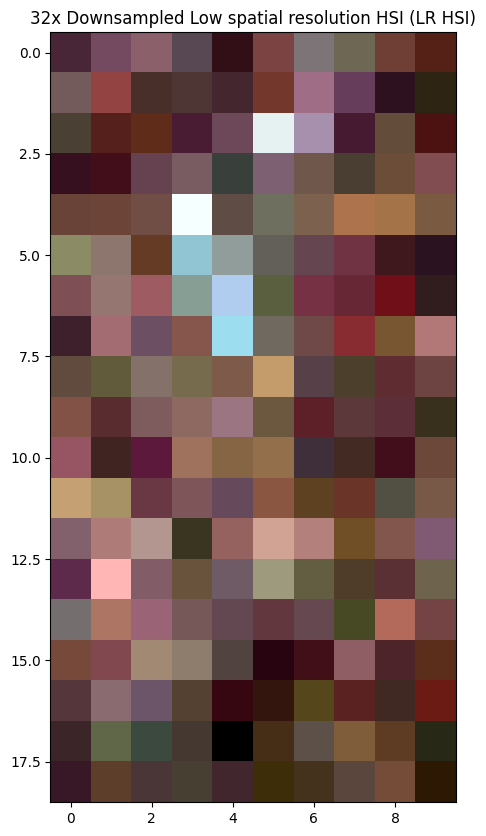

In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(pavia_university_image, sinc_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_sinc.shape)
visualize_hsi(I_HS_4_sinc, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(pavia_university_image, sinc_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_sinc.shape)
visualize_hsi(I_HS_8_sinc, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(pavia_university_image, sinc_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_sinc.shape)
visualize_hsi(I_HS_16_sinc, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(pavia_university_image, sinc_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_sinc.shape)
visualize_hsi(I_HS_32_sinc, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI shape with 4x Downsample:  (152, 85, 103)


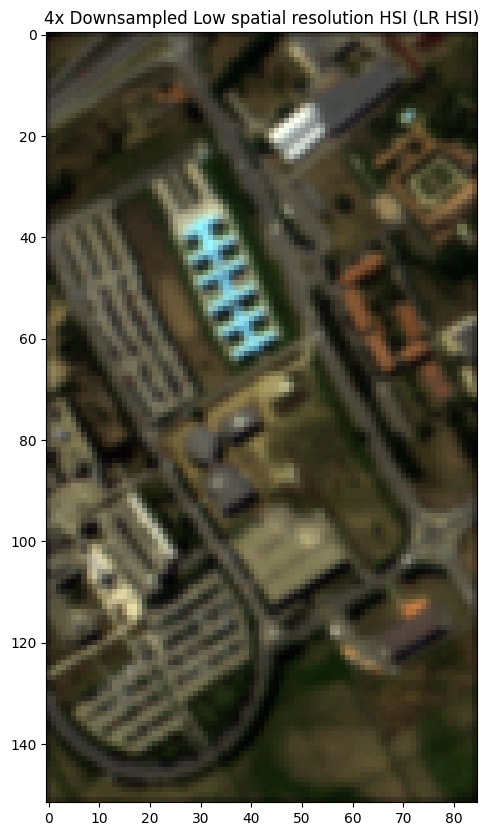

HSI shape with 8x Downsample:  (76, 42, 103)


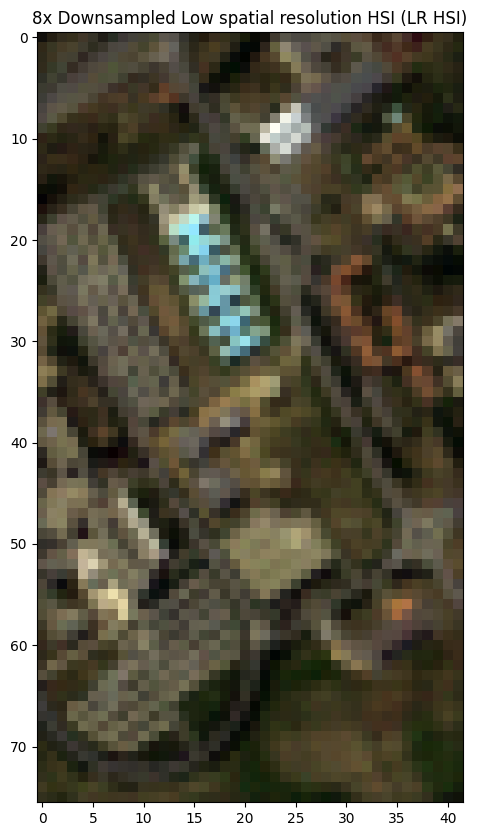

HSI shape with 16x Downsample:  (38, 21, 103)


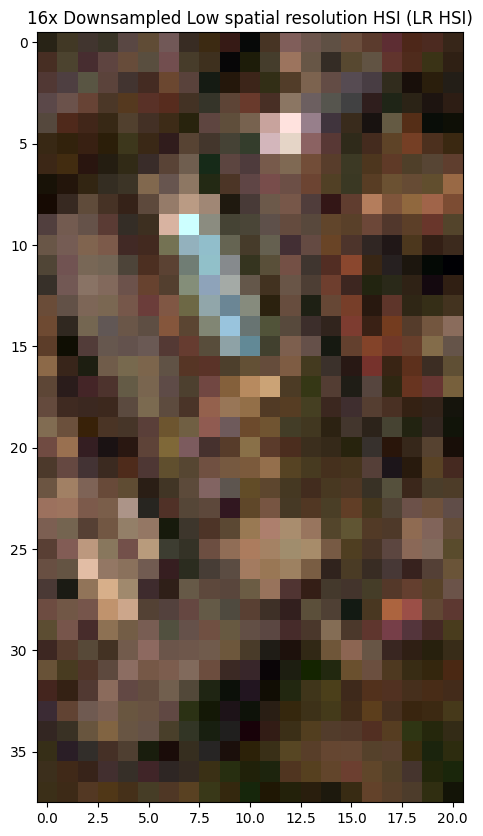

HSI shape with 32x Downsample:  (19, 10, 103)


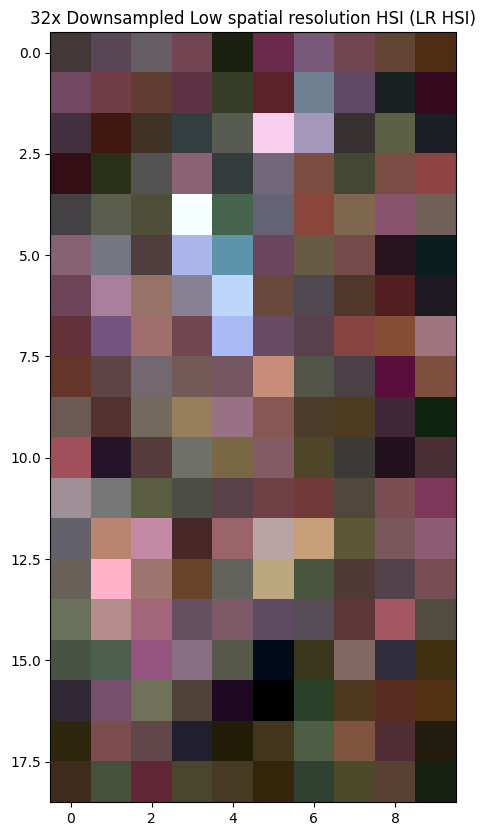

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_lor_sq.shape)
visualize_hsi(I_HS_4_lor_sq, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_lor_sq.shape)
visualize_hsi(I_HS_8_lor_sq, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_lor_sq.shape)
visualize_hsi(I_HS_16_lor_sq, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_lor_sq.shape)
visualize_hsi(I_HS_32_lor_sq, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Hermite PSF

In [ ]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(pavia_university_image, her_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_her.shape)
visualize_hsi(I_HS_4_her, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(pavia_university_image, her_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_her.shape)
visualize_hsi(I_HS_8_her, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(pavia_university_image, her_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_her.shape)
visualize_hsi(I_HS_16_her, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(pavia_university_image, her_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_her.shape)
visualize_hsi(I_HS_32_her, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Parabolic PSF

HSI shape with 4x Downsample:  (152, 85, 103)


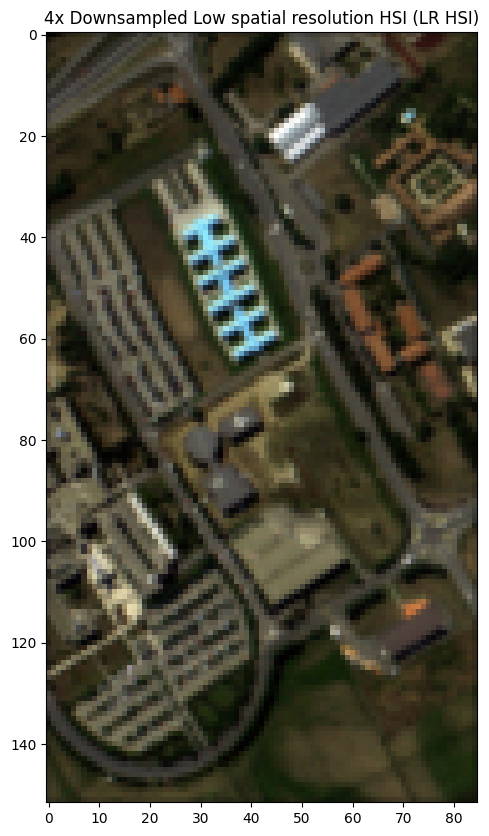

HSI shape with 8x Downsample:  (76, 42, 103)


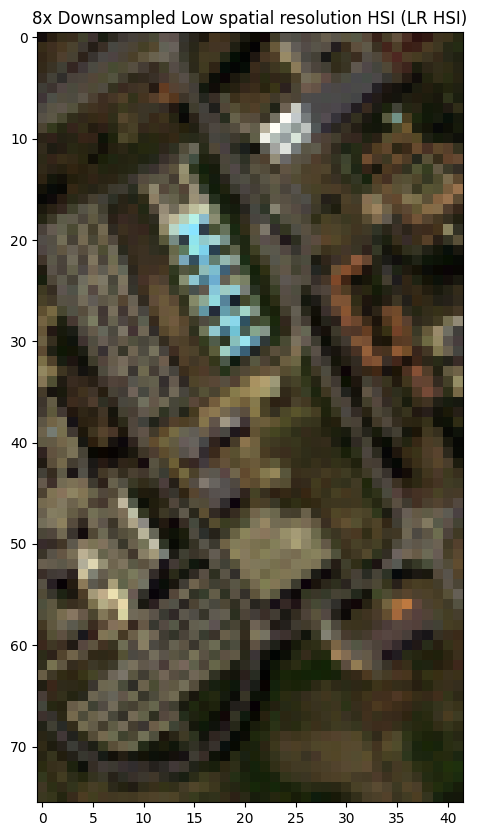

HSI shape with 16x Downsample:  (38, 21, 103)


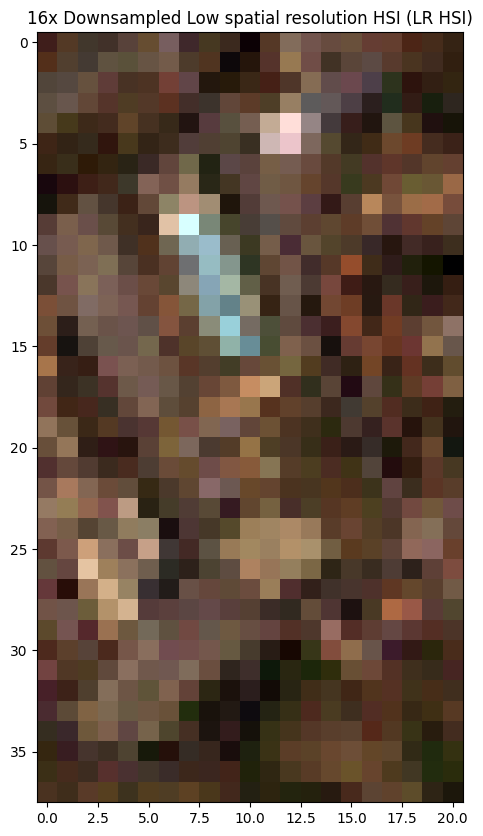

HSI shape with 32x Downsample:  (19, 10, 103)


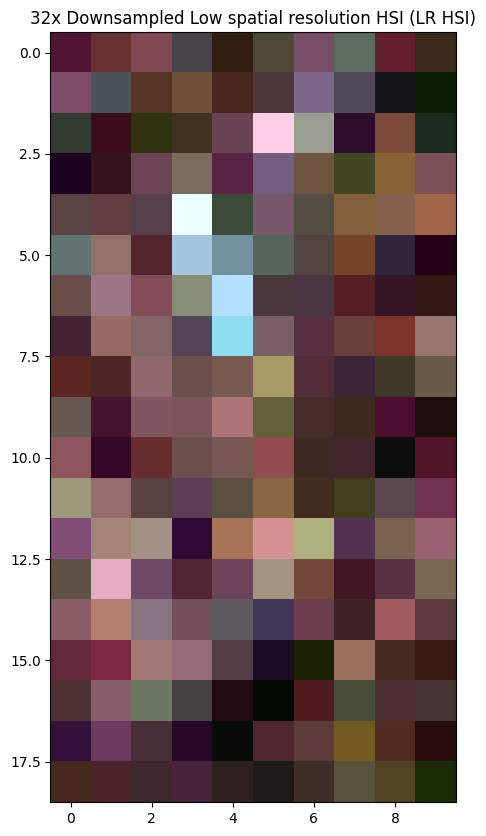

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(pavia_university_image, par_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_par.shape)
visualize_hsi(I_HS_4_par, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(pavia_university_image, par_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_par.shape)
visualize_hsi(I_HS_8_par, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(pavia_university_image, par_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_par.shape)
visualize_hsi(I_HS_16_par, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(pavia_university_image, par_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_par.shape)
visualize_hsi(I_HS_32_par, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Gabor PSF

HSI shape with 16x Downsample:  (38, 21, 103)


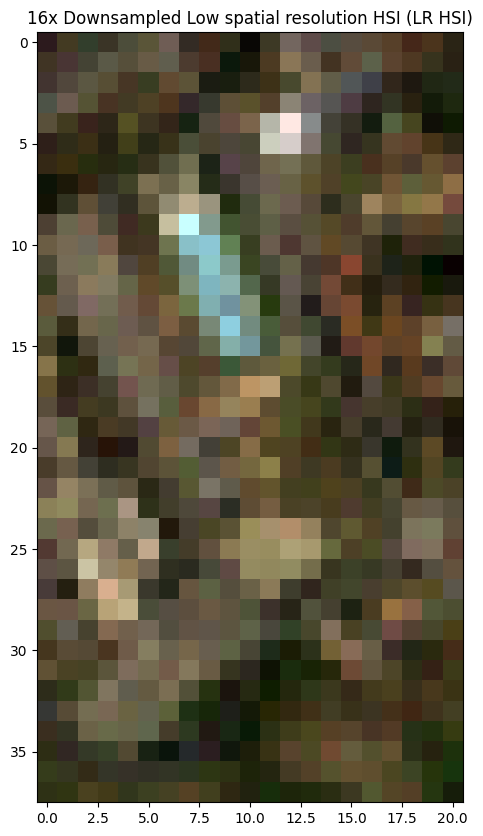

HSI shape with 32x Downsample:  (19, 10, 103)


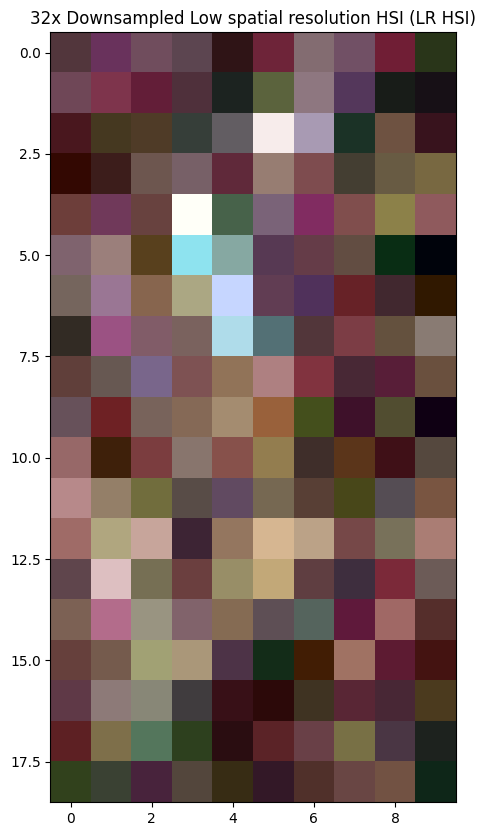

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(pavia_university_image, gab_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gab.shape)
visualize_hsi(I_HS_4_gab, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(pavia_university_image, gab_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gab.shape)
visualize_hsi(I_HS_8_gab, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(pavia_university_image, gab_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gab.shape)
visualize_hsi(I_HS_16_gab, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(pavia_university_image, gab_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gab.shape)
visualize_hsi(I_HS_32_gab, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Delta PSF

HSI shape with 4x Downsample:  (152, 85, 103)


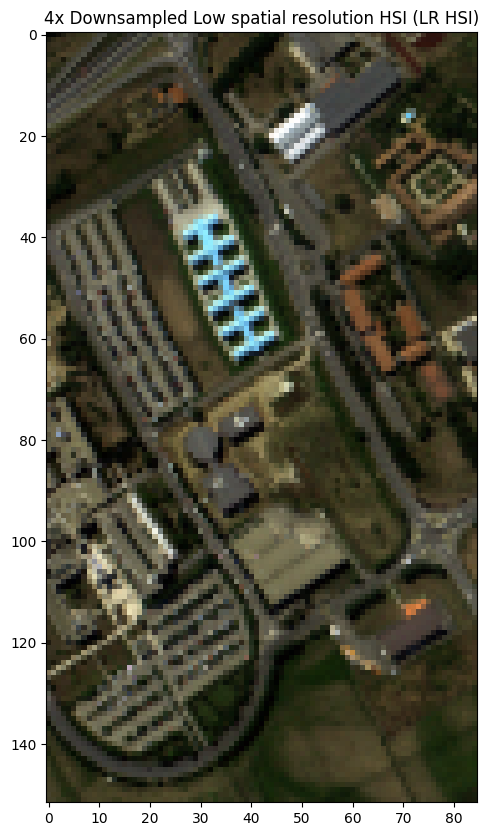

HSI shape with 8x Downsample:  (76, 42, 103)


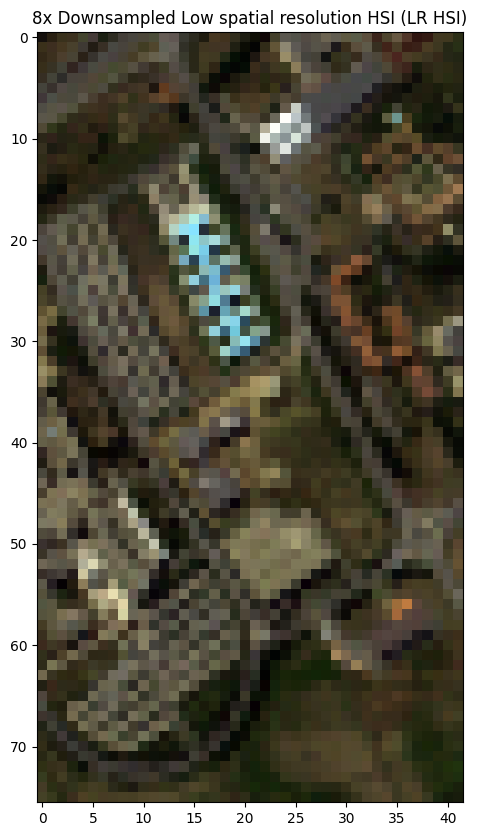

HSI shape with 16x Downsample:  (38, 21, 103)


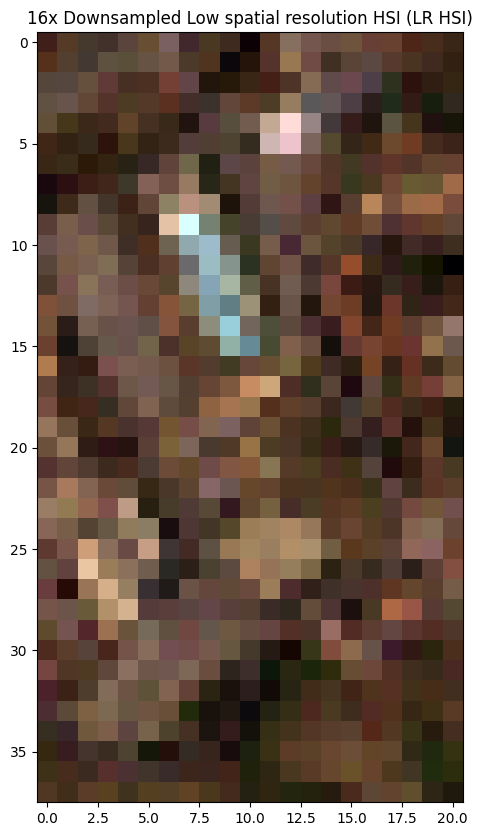

HSI shape with 32x Downsample:  (19, 10, 103)


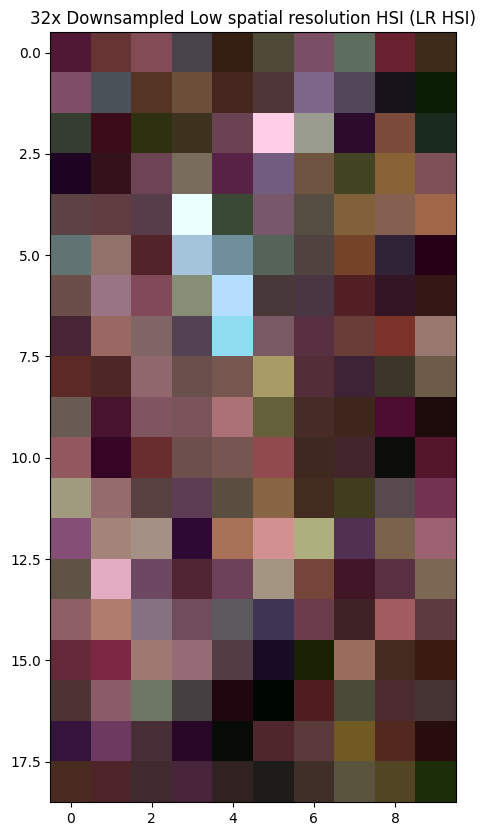

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(pavia_university_image, delta_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_delta.shape)
visualize_hsi(I_HS_4_delta, (50,35,15), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(pavia_university_image, delta_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_delta.shape)
visualize_hsi(I_HS_8_delta, (50,35,15), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(pavia_university_image, delta_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_delta.shape)
visualize_hsi(I_HS_16_delta, (50,35,15), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(pavia_university_image, delta_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_delta.shape)
visualize_hsi(I_HS_32_delta, (50,35,15), "32x Downsampled Low spatial resolution HSI (LR HSI)")

SDP: A Spectral Diffusion Prior for Unsupervised Hyperspectral Image Super-Resolution implementation from their GitHub

In [14]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (real_input_tensor,)).

    Returns
    -------
    flops_total : int
        Total number of FLOPs.
    total_params : int
        Total number of parameters.
    param_table : str
        Table showing parameters by layer.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()

        params = parameter_count(model)
        total_params = sum(params.values())
        param_table = parameter_count_table(model, max_depth=2)

    return flops_total, total_params, param_table

In [15]:
# model/gaussian_diffusion.py

# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


# some helpful functions to compute loss
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    KL divergence between normal distributions parameterized by mean and log-variance.
    """
    return 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) +
                  ((mean1 - mean2) ** 2) * torch.exp(-logvar2))


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * (x ** 3))))


def discretized_gaussian_log_likelihood(x, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image, using the eq(13) of the paper DDPM.
    """
    assert x.shape == means.shape == log_scales.shape

    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min

    log_probs = torch.where(x < -0.999, log_cdf_plus,
                            torch.where(x > 0.999,
                                        log_one_minus_cdf_min,
                                        torch.log(cdf_delta.clamp(min=1e-12))))

    return log_probs


class GaussianDiffusion:
    def __init__(
            self,
            denoise_fn,
            timesteps=1000,
            beta_schedule='linear',
            improved=False
    ):
        self.denoise_fn = denoise_fn
        self.timesteps = timesteps
        self.improved = improved  # improved DDPM

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
                self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        # self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )

        self.posterior_mean_coef1 = (
                self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
                (1.0 - self.alphas_cumprod_prev)
                * torch.sqrt(self.alphas)
                / (1.0 - self.alphas_cumprod)
        )

    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
                self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
                + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
                self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, x_t, t, clip_denoised=True):
        if self.improved is False:
            # predict noise using model
            pred_noise = self.denoise_fn(x_t, t)
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            model_mean, model_variance, model_log_variance = \
                self.q_posterior_mean_variance(x_recon, x_t, t)
        else:
            # predict noise and variance_vector using model
            model_output = self.denoise_fn(x_t, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute predicted variance by eq(15) in the paper
            min_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)  # beta_t~
            max_log_variance = self._extract(torch.log(self.betas), t, x_t.shape)  # beta_t
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
            model_variance = torch.exp(model_log_variance)
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            model_mean, _, _ = \
                self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, shape, device, continuous=False, idx=None):
        batch_size = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        if continuous is False:
            for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
                img = self.p_sample(img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            return img
        else:
            imgs = [img.cpu().detach().numpy()]
            for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
                img = self.p_sample(img, torch.full((batch_size,), i, device=device, dtype=torch.long))
                if idx[i] == 1:
                    imgs.append(img.cpu().detach().numpy())
            return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, shape, device, continuous=False, idx=None):
        return self.p_sample_loop(shape=shape, device=device, continuous=continuous, idx=idx)

    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
            self,
            x_cond,
            image_size,
            batch_size=8,
            channels=3,
            ddim_timesteps=50,
            ddim_discr_method="uniform",
            ddim_eta=0.0,
            clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                    (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        device = x_cond.device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)

            # 2. predict noise using model
            pred_noise = self.denoise_fn(sample_img, x_cond, t)

            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t ** 2) * pred_noise

            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(
                sample_img)

            sample_img = x_prev

        return sample_img

    # compute train losses
    def train_losses(self, x_start):
        t = torch.randint(0, self.timesteps, (x_start.shape[0],), device=x_start.device).long()
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = self.denoise_fn(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        # x_recon = self.predict_start_from_noise(x_noisy, t, predicted_noise)
        return loss

    # use fast sample of DDPM+
    @torch.no_grad()
    def fast_sample(
            self,
            model,
            image_size,
            batch_size=8,
            channels=3,
            timestep_respacing="50",
            clip_denoised=True):
        # make timestep sequence
        # https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/respace.py
        section_counts = [int(x) for x in timestep_respacing.split(",")]
        size_per = self.timesteps // len(section_counts)
        extra = self.timesteps % len(section_counts)
        start_idx = 0
        timestep_seq = []
        for i, section_count in enumerate(section_counts):
            size = size_per + (1 if i < extra else 0)
            if size < section_count:
                raise ValueError(
                    f"cannot divide section of {size} steps into {section_count}"
                )
            if section_count <= 1:
                frac_stride = 1
            else:
                frac_stride = (size - 1) / (section_count - 1)
            cur_idx = 0.0
            taken_steps = []
            for _ in range(section_count):
                taken_steps.append(start_idx + round(cur_idx))
                cur_idx += frac_stride
            timestep_seq += taken_steps
            start_idx += size
        total_timesteps = len(timestep_seq)
        # previous sequence
        timestep_prev_seq = np.append(np.array([-1]), timestep_seq[:-1])

        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, total_timesteps)), desc='sampling loop time step', total=total_timesteps):
            t = torch.full((batch_size,), timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), timestep_prev_seq[i], device=device, dtype=torch.long)

            # get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod_prev, prev_t + 1, sample_img.shape)

            # predict noise using model
            model_output = model(sample_img, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute beta_t and beta_t~ by eq(19) in the paper
            new_beta_t = 1. - alpha_cumprod_t / alpha_cumprod_t_prev
            new_beta_t2 = new_beta_t * (1. - alpha_cumprod_t_prev) / (1. - alpha_cumprod_t)
            min_log_variance = torch.log(new_beta_t2)  # beta_t~
            max_log_variance = torch.log(new_beta_t)  # beta_t
            # compute predicted variance by eq(15) in the paper
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance

            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(sample_img, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            mean_coef1 = (new_beta_t * torch.sqrt(alpha_cumprod_t_prev) / (1.0 - alpha_cumprod_t))
            mean_coef2 = ((1.0 - alpha_cumprod_t_prev) * torch.sqrt(1.0 - new_beta_t) / (1.0 - alpha_cumprod_t))
            model_mean = mean_coef1 * x_recon + mean_coef2 * sample_img

            noise = torch.randn_like(sample_img)
            # no noise when t == 0
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(sample_img.shape) - 1))))
            # compute x_{t-1}
            x_prev = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

            sample_img = x_prev

        return sample_img.cpu().numpy()

    # compute train losses
    def train_ddpm_plus_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)

        # predict
        model_output = model(x_noisy, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)

        # compute VLB loss
        # only learn variance, but use frozen predicted noise
        frozen_output = torch.cat([pred_noise.detach(), pred_variance_v], dim=1)
        # ground truth
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(x_start, x_noisy, t)
        # prediction
        model_mean, _, model_log_variance = self.p_mean_variance(
            lambda *args, r=frozen_output: r,  # use a simple lambda
            t,
            clip_denoised=False
        )
        # for t > 0, compute KL
        kl = normal_kl(true_mean, true_log_variance_clipped, model_mean, model_log_variance)
        kl = torch.mean(kl, dim=[1, 2, 3]) / np.log(2.0)  # use 2 for log base
        # for t = 0, compute NLL
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, model_mean, 0.5 * model_log_variance)
        decoder_nll = torch.mean(decoder_nll, dim=[1, 2, 3]) / np.log(2.0)
        vlb_loss = torch.where((t == 0), decoder_nll, kl)
        # reweight VLB
        vlb_loss *= self.timesteps / 1000

        # compute MSE loss
        mse_loss = torch.mean((pred_noise - noise) ** 2, dim=[1, 2, 3])

        loss = (mse_loss + vlb_loss).mean()
        return loss

In [16]:
# model/mlp_net.py

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) *
                      torch.arange(start=0, end=half, dtype=torch.float32) /
                      half).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat(
            [embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class Activation(Enum):
    none = 'none'
    relu = 'relu'
    lrelu = 'lrelu'
    silu = 'silu'
    tanh = 'tanh'

    def get_act(self):
        if self == Activation.none:
            return nn.Identity()
        elif self == Activation.relu:
            return nn.ReLU()
        elif self == Activation.lrelu:
            return nn.LeakyReLU(negative_slope=0.2)
        elif self == Activation.silu:
            return nn.SiLU()
        elif self == Activation.tanh:
            return nn.Tanh()
        else:
            raise NotImplementedError()


@dataclass
class MLPSkipNetConfig:
    """
    default MLP
    """
    num_channels: int
    skip_layers: Tuple[int]
    num_hid_channels: int
    num_layers: int
    num_time_emb_channels: int = 64
    activation: Activation = Activation.silu
    use_norm: bool = True
    condition_bias: float = 1
    dropout: float = 0
    last_act: Activation = Activation.none
    num_time_layers: int = 2
    time_last_act: bool = False

    def make_model(self):
        return MLPSkipNet(self)


class MLPLNAct(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            norm: bool,
            use_cond: bool,
            activation: Activation,
            cond_channels: int,
            condition_bias: float = 0,
            dropout: float = 0,
    ):
        super().__init__()
        self.activation = activation
        self.condition_bias = condition_bias
        self.use_cond = use_cond

        self.linear = nn.Linear(in_channels, out_channels)
        self.act = activation.get_act()
        if self.use_cond:
            self.linear_emb = nn.Linear(cond_channels, out_channels)
            self.cond_layers = nn.Sequential(self.act, self.linear_emb)
        if norm:
            self.norm = nn.LayerNorm(out_channels)
        else:
            self.norm = nn.Identity()

        if dropout > 0:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = nn.Identity()

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if self.activation == Activation.relu:
                    init.kaiming_normal_(module.weight,
                                         a=0,
                                         nonlinearity='relu')
                elif self.activation == Activation.lrelu:
                    init.kaiming_normal_(module.weight,
                                         a=0.2,
                                         nonlinearity='leaky_relu')
                elif self.activation == Activation.silu:
                    init.kaiming_normal_(module.weight,
                                         a=0,
                                         nonlinearity='relu')
                else:
                    # leave it as default
                    pass

    def forward(self, x, cond=None):
        x = self.linear(x)
        if self.use_cond:
            # (n, c) or (n, c * 2)
            cond = self.cond_layers(cond)
            cond = (cond, cond)

            # scale shift first
            x = x * (self.condition_bias + cond[0])
            if cond[1] is not None:
                x = x + cond[1]
            # then norm
            x = self.norm(x)
        else:
            # no condition
            x = self.norm(x)
        x = self.act(x)
        x = self.dropout(x)
        return x


class MLPSkipNet(nn.Module):
    """
    concat x to hidden layers
    """
    def __init__(self, conf: MLPSkipNetConfig):
        super().__init__()
        self.conf = conf

        layers = []
        for i in range(conf.num_time_layers):
            if i == 0:
                a = conf.num_time_emb_channels
                b = conf.num_channels
            else:
                a = conf.num_channels
                b = conf.num_channels
            layers.append(nn.Linear(a, b))
            if i < conf.num_time_layers - 1 or conf.time_last_act:
                layers.append(conf.activation.get_act())
        self.time_embed = nn.Sequential(*layers)

        self.layers = nn.ModuleList([])
        for i in range(conf.num_layers):
            if i == 0:
                act = conf.activation
                norm = conf.use_norm
                cond = True
                a, b = conf.num_channels, conf.num_hid_channels
                dropout = conf.dropout
            elif i == conf.num_layers - 1:
                act = Activation.none
                norm = False
                cond = False
                a, b = conf.num_hid_channels, conf.num_channels
                dropout = 0
            else:
                act = conf.activation
                norm = conf.use_norm
                cond = True
                a, b = conf.num_hid_channels, conf.num_hid_channels
                dropout = conf.dropout

            if i in conf.skip_layers:
                a += conf.num_channels

            self.layers.append(
                MLPLNAct(
                    a,
                    b,
                    norm=norm,
                    activation=act,
                    cond_channels=conf.num_channels,
                    use_cond=cond,
                    condition_bias=conf.condition_bias,
                    dropout=dropout,
                ))
        self.last_act = conf.last_act.get_act()

    def forward(self, x, t, **kwargs):
        t = timestep_embedding(t, self.conf.num_time_emb_channels)
        cond = self.time_embed(t)
        h = x
        for i in range(len(self.layers)):
            if i in self.conf.skip_layers:
                # injecting input into the hidden layers
                h = torch.cat([h, x], dim=1)
            h = self.layers[i].forward(x=h, cond=cond)
        h = self.last_act(h)
        return h

In [17]:
# utils

class BlurDown:
    def __init__(self, shift_h=0, shift_w=0, stride=0):
        self.shift_h = shift_h
        self.shift_w = shift_w
        self.stride = stride
        pass

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups, ratio):
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        if self.stride == 0:
            output_tensor = F.conv2d(input_tensor, psf, None, (1, 1), (pad, pad), groups=groups)
            output_tensor = output_tensor[:, :, self.shift_h:: ratio, self.shift_h:: ratio]
        else:
            output_tensor = F.conv2d(input_tensor, psf, None, (ratio, ratio), (pad, pad), groups=groups)
        return output_tensor
        
class toolkits:
    # calculate frechet inception distance
    @staticmethod
    def compute_fid(ref: np.ndarray, tar: np.ndarray):
        # ref, tar: num x features
        # calculate mean and covariance statistics
        mu1, sigma1 = ref.mean(axis=0), np.cov(ref, rowvar=False)
        mu2, sigma2 = tar.mean(axis=0), np.cov(tar, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        # calculate sqrt of product between cov
        covmean = sp.linalg.sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    @staticmethod
    def compute_psnr(img1: np.ndarray, img2: np.ndarray, channel=False):
        assert img1.ndim == 3 and img2.ndim == 3
        img_h, img_w, img_c = img1.shape
        ref = img1.reshape(-1, img_c)
        tar = img2.reshape(-1, img_c)
        msr = np.mean((ref - tar) ** 2, 0)
        if channel is False:
            max2 = np.max(ref) ** 2  # channel-wise ???
        else:
            max2 = np.max(ref, axis=0) ** 2
        psnrall = 10 * np.log10(max2 / msr)
        out_mean = np.mean(psnrall)
        return out_mean

    @staticmethod
    def psnr_fun(ref: np.ndarray, tar: np.ndarray):
        assert ref.ndim == 4 and tar.ndim == 4
        b, c, h, w = ref.shape
        ref = ref.reshape(b, c, h * w)
        tar = tar.reshape(b, c, h * w)
        msr = np.mean((ref - tar) ** 2, 2)
        max2 = np.max(ref, axis=2) ** 2
        psnrall = 10 * np.log10(max2 / msr)
        return np.mean(psnrall)

    @staticmethod
    def sam_fun(ref: np.ndarray, tar: np.ndarray):
        assert ref.ndim == 4 and tar.ndim == 4
        b, c, h, w = ref.shape
        x_norm = np.sqrt(np.sum(np.square(ref), axis=1))
        y_norm = np.sqrt(np.sum(np.square(tar), axis=1))
        xy_norm = np.multiply(x_norm, y_norm)
        xy = np.sum(np.multiply(ref, tar), axis=1)
        dist = np.mean(np.arccos(np.minimum(np.divide(xy, xy_norm + 1e-8), 1.0 - 1.0e-9)))
        dist = np.multiply(180.0 / np.pi, dist)
        return dist

    @staticmethod
    def compute_sam(label: np.ndarray, output: np.ndarray):
        h, w, c = label.shape
        x_norm = np.sqrt(np.sum(np.square(label), axis=-1))
        y_norm = np.sqrt(np.sum(np.square(output), axis=-1))
        xy_norm = np.multiply(x_norm, y_norm)
        xy = np.sum(np.multiply(label, output), axis=-1)
        dist = np.mean(np.arccos(np.minimum(np.divide(xy, xy_norm + 1e-8), 1.0 - 1.0e-9)))
        dist = np.multiply(180.0 / np.pi, dist)
        return dist

    @staticmethod
    def check_dir(path: str):
        if not os.path.exists(path):
            os.makedirs(path)

    @staticmethod
    def channel_last(input_tensor: np.ndarray, squeeze=True):
        if squeeze is True:
            input_tensor = np.squeeze(input_tensor)
        input_tensor = np.transpose(input_tensor, axes=(1, 2, 0))
        return input_tensor

    @staticmethod
    def channel_first(input_tensor: np.ndarray, expand=True):
        input_tensor = np.transpose(input_tensor, axes=(2, 0, 1))
        if expand is True:
            input_tensor = np.expand_dims(input_tensor, axis=0)
        return input_tensor

class torchkits:
    @staticmethod
    def sparse_to_torch(input_tensor: sp.coo_matrix):
        values = input_tensor.data
        indices = np.vstack((input_tensor.row, input_tensor.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = input_tensor.shape
        input_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
        return input_tensor

    @staticmethod
    def extract_patches(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)
        all_patches = torch.reshape(all_patches, shape=(N * H * W, C, h, w))
        return all_patches

    @staticmethod
    def extract_patches_v1(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        N, C, H, W = input_tensor.shape
        unfold = torch.nn.Unfold(kernel_size=(kernel, kernel), stride=stride)
        all_patches = unfold(input_tensor)
        _, _, L = all_patches.shape
        all_patches = torch.reshape(all_patches, shape=(N, C, kernel, kernel, L))
        all_patches = all_patches.permute(0, 4, 1, 2, 3)
        all_patches = torch.reshape(all_patches, shape=(N * L, C, kernel, kernel))
        return all_patches

    @staticmethod
    def extract_patches_ex(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        # N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)  # shape=(N, H, W, C, h, w)
        return all_patches

    @staticmethod
    def aggregate_patches(input_tensor: torch.Tensor, height, width, kernel, stride, pad_num=0, patch=1):
        N, C, h, w = input_tensor.shape
        dH = height + 2 * pad_num - (height + 2 * pad_num - kernel) // stride * stride - kernel
        dW = width + 2 * pad_num - (width + 2 * pad_num - kernel) // stride * stride - kernel
        height, width = height - dH, width - dW
        input_tensor = input_tensor.reshape(patch, N // patch, C, h, w)
        output_tensor = input_tensor.permute(0, 2, 3, 4, 1)
        output_tensor = torch.reshape(output_tensor, shape=(patch, C * h * w, N // patch))
        num = torch.ones_like(output_tensor)
        fold = torch.nn.Fold(output_size=(height + 2 * pad_num, width + 2 * pad_num),
                             kernel_size=(kernel, kernel),
                             stride=stride)
        output_tensor = fold(output_tensor)
        num = fold(num)
        output_tensor = output_tensor[:, :, pad_num: height + pad_num, pad_num: width + pad_num]
        num = num[:, :, pad_num: height + pad_num, pad_num: width + pad_num]
        output_tensor = output_tensor / num
        return output_tensor, dH, dW

    @staticmethod
    def torch_cb_loss(ref: torch.Tensor, tar: torch.Tensor, eps=1e-6):
        diff = ref - tar
        loss = torch.sqrt(diff * diff + eps)
        loss = torch.sum(loss)
        return loss

    @staticmethod
    def torch_norm(input_tensor: torch.Tensor, mode=1, reduce=False):
        if mode == 1:
            if reduce is False:
                loss = torch.sum(torch.abs(input_tensor))
            else:
                loss = torch.mean(torch.abs(input_tensor))
            return loss
        return None

    @staticmethod
    def torch_sam(label: torch.Tensor, output: torch.Tensor, reduce=True, angle=True):
        x_norm = torch.sqrt(torch.sum(torch.square(label), dim=-1))
        y_norm = torch.sqrt(torch.sum(torch.square(output), dim=-1))
        xy_norm = torch.multiply(x_norm, y_norm)
        xy = torch.sum(torch.multiply(label, output), dim=-1)
        dist = torch.divide(xy, torch.maximum(xy_norm, torch.tensor(1e-8)))
        dist = torch.arccos(dist)
        if angle is True:
            dist = torch.multiply(torch.tensor(180.0 / np.pi), dist)
        if reduce is True:
            dist = torch.mean(dist)
        else:
            dist = torch.sum(dist)
        return dist

    @staticmethod
    def torch_psnr(ref: torch.Tensor, tar: torch.Tensor):
        b, c, h, w = ref.shape
        ref = ref.reshape(b, c, h * w)
        tar = tar.reshape(b, c, h * w)
        msr = torch.mean(torch.pow(ref - tar, 2), dim=2)
        max2 = torch.pow(torch.max(ref, dim=2)[0], 2)
        psnrall = 10 * torch.log10(max2 / msr)
        return torch.mean(psnrall)

    @staticmethod
    def sparsity_l1_div_l2(x: torch.Tensor):
        N, C, H, W = x.shape  # perform on mode-C
        l1norm = torch.sum(torch.abs(x), dim=1)
        l2norm = torch.sqrt(torch.sum(torch.square(x), dim=1))
        sparsity = torch.sum(l1norm / l2norm)
        return sparsity

    @staticmethod
    def joint_sparsity(x: torch.Tensor):
        N, H, W = x.shape  # perform on mode H, W
        l2norm = torch.sqrt(torch.sum(torch.square(x), dim=2))
        l21norm = torch.sum(l2norm, dim=1)
        fnorm = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2))) + 1e-9
        return torch.sum(l21norm / fnorm)

    @staticmethod
    def sp_joint_l1_div_l2(img: torch.Tensor, jdx: torch.Tensor):
        _, C, W, H = img.shape
        output = torch.squeeze(img)
        output = torch.reshape(output, shape=(C, W * H))
        output = torch.transpose(output, 0, 1)
        output = torch.square(output)
        output = torch.matmul(jdx, output)
        l1norm = torch.sum(torch.sqrt(output), dim=1)
        l2norm = torch.sum(output, dim=1)
        output = torch.sum(l1norm / l2norm)
        return output

    @staticmethod
    def sp_joint_l21(img: torch.Tensor, jdx: torch.Tensor):
        _, C, W, H = img.shape
        output = torch.squeeze(img)
        output = torch.reshape(output, shape=(C, W * H))
        output = torch.transpose(output, 0, 1)
        output = torch.square(output)
        output = torch.matmul(jdx, output)
        output = torch.sqrt(output)
        output = torch.sum(output)
        return output

    @staticmethod
    def superpixel_mean(img: torch.Tensor, jdx: torch.Tensor, jdx_n: torch.Tensor):
        _, C, W, H = img.shape
        output_tensor = torch.squeeze(img)
        output_tensor = torch.reshape(output_tensor, shape=(C, W * H))
        output_tensor = torch.transpose(output_tensor, 0, 1)
        output_tensor = torch.matmul(jdx_n, output_tensor)
        output_tensor = torch.matmul(jdx, output_tensor)
        output_tensor = torch.transpose(output_tensor, 0, 1)
        output_tensor = torch.reshape(output_tensor, shape=(1, C, W, H))
        return output_tensor

    @staticmethod
    def get_param_num(model):
        num = sum(x.numel() for x in model.parameters())
        print("model has {} parameters in total".format(num))
        return num

    @staticmethod
    def to_numpy(val: torch.Tensor):
        return val.cpu().detach().numpy()

In [18]:
# ------------- light wrappers around the authors’ network -------------
class SpecDiffusionNet(nn.Module):
    def __init__(self, bands, layers, hidden, timesteps):
        super().__init__()
        self.timesteps = timesteps
        self.net = MLPSkipNetConfig(
            num_channels=bands, skip_layers=tuple(range(1, layers)),
            num_hid_channels=hidden, num_layers=layers,
            num_time_emb_channels=64, activation=Activation.silu,
            dropout=0.001).make_model()
        self.diff = GaussianDiffusion(self.net, timesteps, beta_schedule='linear')

    def forward(self, x):                         # loss for training
        return self.diff.train_losses(x)

In [19]:
# ----------------------------------------------------------------------
@dataclass
class SDMConfig:
    # spectral diffusion prior
    epochs:      int   = 30000
    lr:          float = 0.01
    batch_size:  int   = 512          # use None to feed *all* spectra each step
    layers:      int   = 4
    hidden:      int   = 512
    timesteps:   int   = 1000

@dataclass
class SDPConfig:
    # test‑time reconstruction
    lam_gamma: float = 1e-3
    inner_K:   int   = 3
    lr:        float = 0.001

In [20]:
# ---------------------- SDM (learn the prior) -------------------------
def train_sdm(spec_matrix: torch.Tensor,
              cfg: SDMConfig,
              device: torch.device = torch.device('cuda')) -> SpecDiffusionNet:
    """
    Train the spectral‑diffusion model exactly as described in the paper:

        • 30 000 gradient *updates* (cfg.epochs)  
        • batch‑size 512, Adam(lr=0.01)  
        • linear‑β scheduler, T = 1000

    The function now performs **one mini‑batch per update** instead of
    looping over the entire dataset each epoch, so the wall‑time is the
    same as the authors’ implementation (≈ 10 min on a modern GPU).
    """
    # ----------------------------------------------------------------
    # network, optimiser, LR scheduler
    # ----------------------------------------------------------------
    net   = SpecDiffusionNet(spec_matrix.size(1),
                             cfg.layers, cfg.hidden,
                             cfg.timesteps).to(device)
    opt   = torch.optim.Adam(net.parameters(), lr=cfg.lr)
    sched = torch.optim.lr_scheduler.LambdaLR(
                opt, lambda i: 0.001 * max(1000 - i/10, 1))

    # bring the training spectra to GPU once
    spec_matrix = spec_matrix.to(device)          # (Npix, C)
    Npix        = spec_matrix.size(0)
    B           = cfg.batch_size or Npix          # default: whole set

    # ----------------------------------------------------------------
    # 30 000 *iterations*  (cfg.epochs == #updates, not #passes)
    # ----------------------------------------------------------------
    net.train()
    pbar = trange(cfg.epochs, desc='SDM', dynamic_ncols=True)
    for step in pbar:
        idx   = torch.randint(0, Npix, (B,), device=device)
        batch = spec_matrix[idx]                  # (B, C)

        loss  = net(batch)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step();  sched.step()

        pbar.set_postfix(loss=f'{loss.item():.3e}')

    # ----------------------------------------------------------------
    # freeze weights for inference
    # ----------------------------------------------------------------
    net.eval()
    for p in net.parameters():
        p.requires_grad = False
    return net

In [21]:
def reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        *, lam_A=0.1, lam_B=1.0, gamma=1e-3,
        inner_K=3, lr=2.5e-3, device='cuda'):

    C_hs, H_lr, W_lr = hsi_lr.shape[1:]
    H, W             = msi_hr.shape[1:]
    pad              = (psf.size(-1) - 1) // 2

    hsi_lr, msi_hr, psf, srf = [t.to(device) for t in
                                (hsi_lr, msi_hr, psf, srf)]

    # ------------ learnable HR‑HSI ---------------------------------
    img = torch.rand(1, C_hs, H, W, device=device, requires_grad=True)
    opt = torch.optim.Adam([img], lr=lr, weight_decay=1e-6)

    blur = BlurDown(shift_h=ratio//2, shift_w=ratio//2)

    # ------------ fidelity term ------------------------------------
    def data_fidelity(x):
        y = blur(x, psf, pad, C_hs, ratio)[..., :H_lr, :W_lr]
        z = F.conv2d(x, srf)                         # ← no extra scaling
        return (lam_A * F.mse_loss(y, hsi_lr, reduction='sum') +
                lam_B * F.mse_loss(z.squeeze(0), msi_hr, reduction='sum'))

    # ------------ optimisation loop --------------------------------
    pbar = trange(sdm.timesteps, desc='SDP', dynamic_ncols=True)
    for t_scalar in pbar:
        t = torch.full((H*W,), sdm.timesteps-1-t_scalar,
                       device=device, dtype=torch.long)

        loss_acc = 0.
        for _ in range(inner_K):
            x     = img.clamp(0, 1)                       # value for loss
            spec  = x.view(1, C_hs, -1).transpose(1, 2).squeeze()
            noise = torch.randn_like(spec)

            xt  = sdm.diff.q_sample(spec, t, noise)
            eps = sdm.diff.denoise_fn(xt, t)

            loss = data_fidelity(x) + gamma * F.mse_loss(eps, noise, reduction='sum')
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            img.data.clamp_(0, 1)                         # ← **new**
            loss_acc += loss.item()

        pbar.set_postfix(loss=f'{loss_acc/inner_K:7.3e}')

    return img.detach().squeeze(0)        # (C_hs, H, W) in [0,1]

In [22]:
def run_single_sdp_forward(sdm, hsi_lr, msi_hr, psf, srf, ratio, device='cuda'):
    """
    Profiles a single forward pass (at midpoint timestep) of SDP.
    """
    sdm.eval()

    B, C_hs, h_lr, w_lr = hsi_lr.shape
    _, C_ms, h_hr, w_hr = msi_hr.shape
    pad = (psf.size(-1) - 1) // 2

    hsi_lr = hsi_lr.to(device)
    msi_hr = msi_hr.to(device)
    psf = psf.to(device)
    srf = srf.to(device)

    img = torch.rand(B, C_hs, h_hr, w_hr, device=device)
    blur = BlurDown(shift_h=ratio // 2, shift_w=ratio // 2)

    torch.cuda.reset_peak_memory_stats()

    # --- Start memory measurement ---
    start_memory_bytes = torch.cuda.max_memory_allocated()
    start_time = time.perf_counter()

    with torch.no_grad():
        x = img.clamp(0, 1)
        spec = x.view(B, C_hs, -1).transpose(1, 2).reshape(-1, C_hs)
        noise = torch.randn_like(spec)

        t_scalar = int(sdm.timesteps // 2)
        t = torch.full((B * h_hr * w_hr,), t_scalar, device=device, dtype=torch.long)

        xt = sdm.diff.q_sample(spec, t, noise)
        _ = sdm.diff.denoise_fn(xt, t)

        _ = blur(x, psf, pad, C_hs, ratio)[..., :h_lr, :w_lr]
        _ = F.conv2d(x, srf)

    torch.cuda.synchronize()
    end_time = time.perf_counter()

    end_memory_bytes = torch.cuda.max_memory_allocated()
    peak_mem = end_memory_bytes - start_memory_bytes
    
    inference_time = end_time - start_time

    return inference_time, peak_mem

class SDPForwardWrapper(nn.Module):
    def __init__(self, sdm, psf, srf, ratio):
        super().__init__()
        self.sdm = sdm
        self.psf = psf
        self.srf = srf
        self.ratio = ratio

    def forward(self, hsi_lr, msi_hr):
        B, C_hs, h_lr, w_lr = hsi_lr.shape
        _, _, h_hr, w_hr = msi_hr.shape
        pad = (self.psf.size(-1) - 1) // 2

        img = torch.rand(B, C_hs, h_hr, w_hr, device=hsi_lr.device)
        blur = BlurDown(shift_h=self.ratio // 2, shift_w=self.ratio // 2)

        with torch.no_grad():
            x = img.clamp(0, 1)
            spec = x.view(B, C_hs, -1).transpose(1, 2).reshape(-1, C_hs)
            noise = torch.randn_like(spec)

            t_scalar = int(self.sdm.timesteps // 2)
            t = torch.full((B * h_hr * w_hr,), t_scalar, dtype=torch.long, device=hsi_lr.device)

            xt = self.sdm.diff.q_sample(spec, t, noise)
            eps = self.sdm.diff.denoise_fn(xt, t)

            y_pred = blur(x, self.psf, pad, C_hs, self.ratio)[..., :h_lr, :w_lr]
            z_pred = F.conv2d(x, self.srf)

        return eps  # Only shape matters for FLOPs, not value

Output file to save super-resolved images

In [23]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/SDP"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the SDP folder
pavia_u_SDP_folder_path = os.path.join(normalized_target_path, 'Pavia_University')

# Create the SDP folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_folder_path):
    os.makedirs(pavia_u_SDP_folder_path)

In [24]:
def split_image(image, split_index):
    return image[:split_index], image[split_index:]

def extract_part_to_save(image):
    image = image[:608, :320, :]
    _, image = split_image(image, 480)
    return image

## Super Resolving HSI degraded with Gaussian PSF

In [31]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
pavia_u_SDP_gaus_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_gaus_folder_path):
    os.makedirs(pavia_u_SDP_gaus_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [32]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:59<00:00, 250.69it/s, loss=5.300e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=3.985e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  385.47 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0457 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [33]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:59<00:00, 250.12it/s, loss=6.487e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=7.586e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  383.87 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [34]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [02:00<00:00, 249.74it/s, loss=1.427e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=1.205e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  384.96 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0463 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [35]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [02:00<00:00, 249.71it/s, loss=1.169e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s, loss=9.552e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  383.30 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0465 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [36]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:58<00:00, 252.39it/s, loss=6.932e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.79it/s, loss=7.539e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.96 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0472 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [37]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.86it/s, loss=7.298e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=7.591e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.57 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0469 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [38]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 255.52it/s, loss=7.890e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=7.560e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.26 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_gaus_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [39]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gaus.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gaus.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gaus_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gaus_folder_path}/SR_Pavia_U_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_gaus_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.77it/s, loss=9.079e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=9.923e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.78 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0459 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov HSI

In [40]:
# Creating sub folder within which to save the super resolved images from Kolmogorov PSF degraded HSI
pavia_u_SDP_kol_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Kolmogorov_PSF')

# Create the Kolmogorov sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_kol_folder_path):
    os.makedirs(pavia_u_SDP_kol_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [41]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [02:02<00:00, 243.94it/s, loss=5.399e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=4.099e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  387.36 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0465 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [42]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.89it/s, loss=6.273e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=7.474e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  379.21 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.12 MB
Inference time: 0.0464 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [43]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 256.10it/s, loss=1.131e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=1.253e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  379.56 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [44]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [02:00<00:00, 248.87it/s, loss=1.315e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=9.411e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  385.42 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.84 MB
Inference time: 0.0478 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [45]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.96it/s, loss=7.081e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=7.534e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.58 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [46]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.72it/s, loss=6.493e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=7.605e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.81 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0469 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [47]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:58<00:00, 252.11it/s, loss=6.160e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s, loss=7.691e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.37 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0463 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_kol_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [48]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_kol.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_kol.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(kol_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_kol_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.65it/s, loss=6.497e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=1.011e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  379.43 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0457 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_kol_folder_path


## Super Resolving HSI degraded with Airy HSI

In [25]:
# Creating sub folder within which to save the super resolved images from Airy PSF degraded HSI
pavia_u_SDP_air_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Airy_PSF')

# Create the Airy sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_air_folder_path):
    os.makedirs(pavia_u_SDP_air_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [26]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.05it/s, loss=6.022e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=4.343e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  379.70 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0458 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [27]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 258.08it/s, loss=6.957e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s, loss=7.888e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  377.67 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0463 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [28]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.78it/s, loss=1.456e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=1.215e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.85 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0463 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [29]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 256.38it/s, loss=1.180e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=9.334e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.62 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0464 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [30]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 257.51it/s, loss=7.280e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.824e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.66 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0462 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [31]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.87it/s, loss=7.753e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.82it/s, loss=7.897e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.19 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0460 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [32]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.07it/s, loss=8.323e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s, loss=7.893e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.34 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_air_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [33]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_air.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_air.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(air_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_air_folder_path}/SR_Pavia_U_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_air_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.70it/s, loss=9.535e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s, loss=1.017e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.63 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0457 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_air_folder_path


## Super Resolving HSI degraded with Moffat HSI

In [58]:
# Creating sub folder within which to save the super resolved images from Moffat PSF degraded HSI
pavia_u_SDP_mof_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Moffat_PSF')

# Create the Moffat sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_mof_folder_path):
    os.makedirs(pavia_u_SDP_mof_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [59]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 255.00it/s, loss=8.657e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=4.162e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.26 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.22 MB
Inference time: 0.0458 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [60]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:58<00:00, 253.18it/s, loss=6.108e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=7.792e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  381.10 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.75 MB
Inference time: 0.0459 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [61]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 255.67it/s, loss=9.073e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=1.228e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  379.66 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0463 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [62]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:57<00:00, 254.31it/s, loss=1.362e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s, loss=9.421e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  384.24 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.25 MB
Inference time: 0.0479 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [63]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 257.18it/s, loss=7.820e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=7.734e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.89 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0474 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [64]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.92it/s, loss=6.159e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s, loss=7.682e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.70 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0473 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [65]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.85it/s, loss=7.196e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=7.747e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.95 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0458 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_mof_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [66]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_mof.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_mof.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(mof_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_mof_folder_path}/SR_Pavia_U_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_mof_folder_path")

SDM: 100%|██████████| 30000/30000 [01:56<00:00, 256.92it/s, loss=9.355e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s, loss=1.008e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  383.73 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0469 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_mof_folder_path


## Super Resolving HSI degraded with Sinc HSI

In [27]:
# Creating sub folder within which to save the super resolved images from Sinc PSF degraded HSI
pavia_u_SDP_sinc_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Sinc_PSF')

# Create the Sinc sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_sinc_folder_path):
    os.makedirs(pavia_u_SDP_sinc_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [28]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:11<00:00, 227.31it/s, loss=7.140e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s, loss=5.128e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  401.89 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0468 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [29]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.95it/s, loss=7.165e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=8.178e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  397.84 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0466 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [30]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.42it/s, loss=1.451e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=1.229e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.19 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0472 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [31]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.86it/s, loss=1.218e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=9.563e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  397.45 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0466 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [32]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.85it/s, loss=7.437e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=7.988e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  397.09 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0472 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [33]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.67it/s, loss=7.984e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=8.166e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.30 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0470 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [34]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.45it/s, loss=8.482e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=8.237e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.36 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_sinc_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [35]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_sinc.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_sinc.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(sinc_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_sinc_folder_path}/SR_Pavia_U_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_sinc_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.37it/s, loss=9.732e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s, loss=1.052e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.91 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared HSI

In [36]:
# Creating sub folder within which to save the super resolved images from Lorentzian Squared PSF degraded HSI
pavia_u_SDP_lor_sq_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Lorentzian_Squared_PSF')

# Create the Lorentzian Squared sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_lor_sq_folder_path):
    os.makedirs(pavia_u_SDP_lor_sq_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [37]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.17it/s, loss=5.387e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=4.119e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.45 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0465 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [38]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.37it/s, loss=6.275e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s, loss=7.499e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.75 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.12 MB
Inference time: 0.0469 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [39]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 224.98it/s, loss=1.129e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=1.252e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.38 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0472 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [40]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.76it/s, loss=1.314e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s, loss=9.493e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  399.45 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.84 MB
Inference time: 0.0475 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [41]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.22it/s, loss=7.081e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.79it/s, loss=7.576e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  397.30 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0470 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [42]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.37it/s, loss=6.455e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s, loss=7.569e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  400.20 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0482 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [43]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.78it/s, loss=6.159e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=7.682e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  397.64 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0470 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [44]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_lor_sq.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_lor_sq.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(lor_sq_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 226.21it/s, loss=6.475e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=1.009e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.08 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0465 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_lor_sq_folder_path


## Super Resolving HSI degraded with Parabolic HSI

In [45]:
# Creating sub folder within which to save the super resolved images from Parabolic PSF degraded HSI
pavia_u_SDP_par_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Parabolic_PSF')

# Create the Parabolic sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_par_folder_path):
    os.makedirs(pavia_u_SDP_par_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [46]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 226.10it/s, loss=7.137e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s, loss=4.475e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.98 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0471 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [47]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:12<00:00, 225.93it/s, loss=8.656e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=7.998e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  398.25 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [48]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 224.89it/s, loss=8.596e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:26<00:00,  3.76it/s, loss=1.212e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  399.50 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0477 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [49]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:13<00:00, 225.39it/s, loss=9.300e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s, loss=9.480e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  401.25 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0482 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [50]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:18<00:00, 217.00it/s, loss=8.388e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=7.805e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  403.01 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0472 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [51]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:17<00:00, 217.80it/s, loss=7.609e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s, loss=7.768e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  403.38 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.58 MB
Inference time: 0.0472 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [52]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:18<00:00, 216.30it/s, loss=1.008e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=7.811e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  404.09 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.90 MB
Inference time: 0.0470 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_par_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [53]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_par.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_par.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(par_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_par_folder_path}/SR_Pavia_U_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_par_folder_path")

SDM: 100%|██████████| 30000/30000 [02:18<00:00, 216.31it/s, loss=7.075e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s, loss=1.020e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  404.67 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.74 MB
Inference time: 0.0460 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_par_folder_path


## Super Resolving HSI degraded with Hermite HSI

In [34]:
# Creating sub folder within which to save the super resolved images from Hermite PSF degraded HSI
pavia_u_SDP_her_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Hermite_PSF')

# Create the Hermite sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_her_folder_path):
    os.makedirs(pavia_u_SDP_her_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [35]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.10it/s, loss=5.109e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s, loss=4.052e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.24 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.09 MB
Inference time: 0.0463 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [36]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.77it/s, loss=6.133e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.399e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  374.86 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.12 MB
Inference time: 0.0459 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [37]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 262.25it/s, loss=1.110e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=1.220e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  374.82 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0455 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [38]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 261.50it/s, loss=1.312e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=9.608e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.22 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.84 MB
Inference time: 0.0470 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [39]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [02:01<00:00, 247.50it/s, loss=6.864e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s, loss=7.490e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.19 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [40]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.61it/s, loss=6.285e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s, loss=7.505e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  377.35 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [41]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.54it/s, loss=6.095e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.587e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.65 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_her_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [42]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_her.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_her.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(her_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_her_folder_path}/SR_Pavia_U_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_her_folder_path")

SDM: 100%|██████████| 30000/30000 [02:01<00:00, 247.17it/s, loss=6.350e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=1.003e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  383.29 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0456 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_her_folder_path


## Super Resolving HSI degraded with Gabor HSI

In [43]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_SDP_gab_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Gabor_PSF')

# Create the Gabor sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_gab_folder_path):
    os.makedirs(pavia_u_SDP_gab_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [44]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 261.37it/s, loss=6.861e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s, loss=4.015e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.56 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0462 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [45]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.22it/s, loss=8.133e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.516e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.06 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [46]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [02:00<00:00, 248.29it/s, loss=8.128e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:22<00:00,  3.82it/s, loss=1.198e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  382.96 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0467 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [47]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 260.91it/s, loss=8.981e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s, loss=9.526e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.30 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0475 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [48]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 259.93it/s, loss=7.689e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.515e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.19 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0463 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [49]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [02:00<00:00, 249.38it/s, loss=7.207e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.522e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.55 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.58 MB
Inference time: 0.0463 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [50]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 259.54it/s, loss=9.280e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s, loss=7.588e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.78 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.90 MB
Inference time: 0.0461 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_gab_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [51]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_gab.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_gab.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(gab_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_gab_folder_path}/SR_Pavia_U_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_gab_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.46it/s, loss=6.559e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s, loss=1.006e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  376.19 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.74 MB
Inference time: 0.0458 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_gab_folder_path


## Super Resolving HSI degraded with Delta HSI

In [52]:
# Creating sub folder within which to save the super resolved images from Delta PSF degraded HSI
pavia_u_SDP_delta_folder_path = os.path.join(pavia_u_SDP_folder_path, 'Delta_PSF')

# Create the Delta sub folder if it doesn't exist
if not os.path.exists(pavia_u_SDP_delta_folder_path):
    os.makedirs(pavia_u_SDP_delta_folder_path)

Running SDP on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [53]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_4_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_4_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_4_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=4

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:59<00:00, 250.33it/s, loss=9.185e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s, loss=4.504e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.83 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.22 MB
Inference time: 0.0457 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [54]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.38it/s, loss=6.329e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=7.928e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.90 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.75 MB
Inference time: 0.0460 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [55]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_16_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_16_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_16_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=16

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.85it/s, loss=9.276e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s, loss=1.230e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.42 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.61 MB
Inference time: 0.0461 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [56]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_32_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_32_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_32_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_4.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_4.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=32

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:59<00:00, 250.50it/s, loss=1.360e-02]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=9.335e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  384.23 seconds
FLOPs: 192660082000
GPU memory consumed: 2491.25 MB
Inference time: 0.0475 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [57]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_1.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_1.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 260.95it/s, loss=8.010e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:20<00:00,  3.85it/s, loss=7.881e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  375.03 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0462 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [58]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_3.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_3.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:54<00:00, 261.48it/s, loss=6.393e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s, loss=7.925e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  377.96 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0469 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [59]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_8.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_8.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:59<00:00, 251.33it/s, loss=7.512e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s, loss=7.898e+03]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  380.52 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0451 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_SDP_delta_folder_path


Running SDP on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [60]:
# --- tensors -------------------------------------------------------
device = torch.device('cuda')

# use *clean* HR cube for SDM
spec_matrix = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
                  .permute(2,0,1)     # (C,H,W)
spec_matrix = spec_matrix.reshape(I_HS_8_delta.shape[2], -1).t().to(device)
#   shape: (H·W, C_hs)

# keep everything in [0,1]  
hsi_lr = torch.from_numpy(I_HS_8_delta.astype(np.float32)) \
              .permute(2,0,1).unsqueeze(0).to(device)
msi_hr = torch.from_numpy(I_MS_16.astype(np.float32)) \
              .permute(2,0,1).to(device)

psf  = torch.from_numpy(delta_psf.astype(np.float32)) \
            .unsqueeze(0).unsqueeze(0).to(device)
srf  = torch.from_numpy(srf_16.astype(np.float32)) \
            .unsqueeze(-1).unsqueeze(-1).to(device)




# --- SDM (training) -----------------------------------------------------------
sdm_cfg = SDMConfig(batch_size=512,    # as in the paper
                    lr=1e-2,
                    epochs=30000,
                    hidden=512,
                    layers=4,
                    timesteps=1000)




# Calculating training time
start_sdm_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
end_sdm_time = time.perf_counter()
sdm_time = end_sdm_time - start_sdm_time


# Create timestep input with shape (N,), where N = spec_matrix.size(0)
t = torch.full((spec_matrix.size(0),), fill_value=200, dtype=torch.long, device=device)
_, num_params, param_table = get_flops_fvcore(sdm.net, (spec_matrix,t))
print(f"Number of parameters: {num_params}")


# ---- SDP (inference) -----------------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=0.001) # Change lr according to image
ratio=8

# Calculating inference time
start_sdp_time = time.perf_counter()
sr = reconstruct_hsi(
        sdm, hsi_lr, msi_hr, psf, srf, ratio,
        gamma   = sdp_cfg.lam_gamma,   # 1e‑3
        inner_K = sdp_cfg.inner_K,     # 3
        lr      = sdp_cfg.lr)          # 0.001
end_sdp_time = time.perf_counter()
total_sdp_time = end_sdp_time - start_sdp_time

total_training_time = total_sdp_time + sdm_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = hsi_lr.shape[1]    # number of hyperspectral bands
C_ms = msi_hr.shape[0]     # number of multispectral bands
h_lr, w_lr = hsi_lr.shape[2], hsi_lr.shape[3]
h_hr, w_hr = msi_hr.shape[1], msi_hr.shape[2]

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# back to [0,1] ‑‑> numpy (H,W,C) for evaluation / saving ------------
SR_image = sr.permute(1,2,0).cpu().numpy()

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_SDP_delta_folder_path}/SR_Pavia_U_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_delta_folder_path")

SDM: 100%|██████████| 30000/30000 [01:55<00:00, 260.75it/s, loss=9.620e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


Number of parameters: 4621108


SDP: 100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s, loss=1.015e+04]
Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


Training completed in  378.78 seconds
FLOPs: 192660082000
GPU memory consumed: 2490.79 MB
Inference time: 0.0471 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_SDP_delta_folder_path
